#### Let's import the required libraries for the case study    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("train.csv")
data.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0,0,NaN,NaN,NaN,1958,0.0,0.0,0.0,0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0,0,NaN,1.0,NaN,710,0.0,0.0,0.0,0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0,0,NaN,NaN,NaN,882,0.0,0.0,0.0,0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0,0,NaN,NaN,NaN,982,0.0,0.0,0.0,0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1,0,1.0,1.0,1.0,647,0.0,0.0,0.0,0


###  Data Understanding, Preparation, and Pre-Processing 

In [3]:
# We have around 172 columns. Let's see their datatypes to know if any are categorical in nature
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 172 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    id                        int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    arpu_6                    float64
 9    arpu_7                    float64
 10   arpu_8                    float64
 11   onnet_mou_6               float64
 12   onnet_mou_7               float64
 13   onnet_mou_8               float64
 14   offnet_mou_6              float64
 15   offnet_mou_7              float64
 16   offnet_mou_8              float64
 17   roam_ic_mou_6             float64
 18   roam_ic_mou_7             float64
 19   roam_ic_mou_8             float64
 20   roam

##### We see that total 9 columns are of object datatype. Let's see the values for these columns and figure out if they would mean any business value.

In [4]:
object_cols = list(data.select_dtypes(include=["object"]).columns)
object_cols

['last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'date_of_last_rech_6',
 'date_of_last_rech_7',
 'date_of_last_rech_8',
 'date_of_last_rech_data_6',
 'date_of_last_rech_data_7',
 'date_of_last_rech_data_8']

In [5]:
data[object_cols]

,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8
0,6/30/2014,7/31/2014,8/31/2014,6/22/2014,7/10/2014,8/24/2014,NaN,NaN,NaN
1,6/30/2014,7/31/2014,8/31/2014,6/12/2014,7/10/2014,8/26/2014,NaN,7/8/2014,NaN
2,6/30/2014,7/31/2014,8/31/2014,6/11/2014,7/22/2014,8/24/2014,NaN,NaN,NaN
3,6/30/2014,7/31/2014,8/31/2014,6/15/2014,7/21/2014,8/25/2014,NaN,NaN,NaN
4,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/26/2014,8/30/2014,6/25/2014,7/23/2014,8/20/2014
...,...,...,...,...,...,...,...,...,...
69994,6/30/2014,7/31/2014,8/31/2014,6/18/2014,7/31/2014,8/31/2014,NaN,7/31/2014,8/21/2014
69995,6/30/2014,7/31/2014,8/31/2014,6/28/2014,7/31/2014,8/27/2014,NaN,NaN,NaN
69996,6/30/2014,7/31/2014,8/31/2014,6/25/2014,7/30/2014,8/29/2014,NaN,NaN,NaN
69997,6/30/2014,7/31/2014,8/31/2014,6/29/2014,7/19/2014,8/26/2014,6/17/2014,7/13/2014,8/14/2014


###### We see that these columns are of date datatype and they simply describe the last date of the month. 
###### From a business point of view, last date of the month will not have any impact on the customer's behaviour as it's a static data. Hence we can exclude this column from further analysis

In [6]:
type(object_cols)

list

In [7]:
data = data.drop(columns=object_cols)
# Let's see if there are any columns left with object data type
data.select_dtypes(include=["object"])

""
0
1
2
3
4
...
69994
69995
69996
69997


##### As we can see from above, no column is left with object data type. Once we have all the data in numeric data type let's move on to checking if there are any null values present in the dataset

In [8]:
data.info(verbose=True, show_counts=True )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Data columns (total 163 columns):
 #    Column              Non-Null Count  Dtype  
---   ------              --------------  -----  
 0    id                  69999 non-null  int64  
 1    circle_id           69999 non-null  int64  
 2    loc_og_t2o_mou      69297 non-null  float64
 3    std_og_t2o_mou      69297 non-null  float64
 4    loc_ic_t2o_mou      69297 non-null  float64
 5    arpu_6              69999 non-null  float64
 6    arpu_7              69999 non-null  float64
 7    arpu_8              69999 non-null  float64
 8    onnet_mou_6         67231 non-null  float64
 9    onnet_mou_7         67312 non-null  float64
 10   onnet_mou_8         66296 non-null  float64
 11   offnet_mou_6        67231 non-null  float64
 12   offnet_mou_7        67312 non-null  float64
 13   offnet_mou_8        66296 non-null  float64
 14   roam_ic_mou_6       67231 non-null  float64
 15   roam_ic_mou_7       67312 non-null

In [9]:
missing_data_percent = 100*data.isnull().sum()/len(data)
missing_data_percent

id                   0.000000
circle_id            0.000000
loc_og_t2o_mou       1.002871
std_og_t2o_mou       1.002871
loc_ic_t2o_mou       1.002871
                       ...   
aon                  0.000000
aug_vbc_3g           0.000000
jul_vbc_3g           0.000000
jun_vbc_3g           0.000000
churn_probability    0.000000
Length: 163, dtype: float64

In [10]:
# We see that there are columns having around 74% missing values, we should be removing these columns as they
# would not be helpful in model building and making prediction
new_vars = missing_data_percent[missing_data_percent.le(40)].index
new_vars

Index(['id', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       ...
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'churn_probability'],
      dtype='object', length=136)

In [11]:
data = data[new_vars]
data

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,31.277,87.009,7.527,48.58,124.38,...,0,0,0,0,0,1958,0.00,0.00,0.00,0
1,1,109,0.0,0.0,0.0,0.000,122.787,42.953,0.00,0.00,...,1,0,0,0,0,710,0.00,0.00,0.00,0
2,2,109,0.0,0.0,0.0,60.806,103.176,0.000,0.53,15.93,...,0,0,0,0,0,882,0.00,0.00,0.00,0
3,3,109,0.0,0.0,0.0,156.362,205.260,111.095,7.26,16.01,...,0,0,0,0,0,982,0.00,0.00,0.00,0
4,4,109,0.0,0.0,0.0,240.708,128.191,101.565,21.28,4.83,...,0,0,0,1,0,647,0.00,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,69994,109,0.0,0.0,0.0,15.760,410.924,329.136,0.00,7.36,...,0,0,0,1,0,221,0.00,0.00,0.00,0
69995,69995,109,0.0,0.0,0.0,160.083,289.129,265.772,116.54,196.46,...,0,0,0,0,0,712,0.00,0.00,0.00,0
69996,69996,109,0.0,0.0,0.0,372.088,258.374,279.782,77.13,68.44,...,0,0,0,0,0,879,0.00,0.00,0.00,0
69997,69997,109,0.0,0.0,0.0,238.575,245.414,145.062,14.01,7.64,...,1,1,0,0,0,277,664.25,1402.96,990.97,0


In [12]:
# We have around 136 columns now, let's see if any of them are having higher percentage of missing values
(100*data.isnull().sum()/len(data)).describe()

count    136.000000
mean       2.811889
std        2.143120
min        0.000000
25%        0.000000
50%        3.838626
75%        3.954342
max        5.290076
dtype: float64

In [13]:
# We see that the missing percentage is very low that is 5 Percent. Lets try imputing zero value for these missing records
data = data.fillna(0)

In [14]:
(100*data.isnull().sum()/len(data)).describe()

count    136.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

### Exploratory Data Analysis

##### Let's check for outliers

In [15]:
def show_box_plot_in_batches(dataarray):
    prev=0
    for i in range(15,len(dataarray.columns),16):
        plt.figure(figsize=(15,8))
        plt.xticks(rotation=45)
        sns.boxplot(data = dataarray.iloc[:,prev:i])
        prev = i

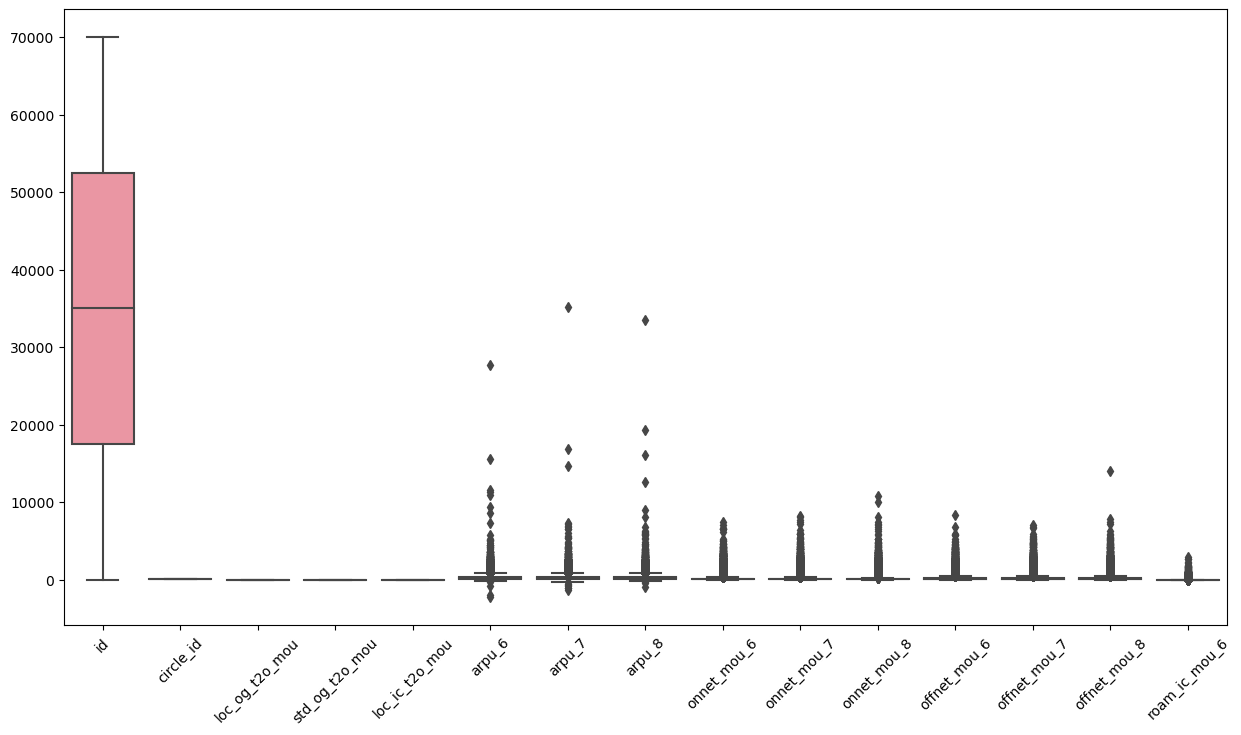

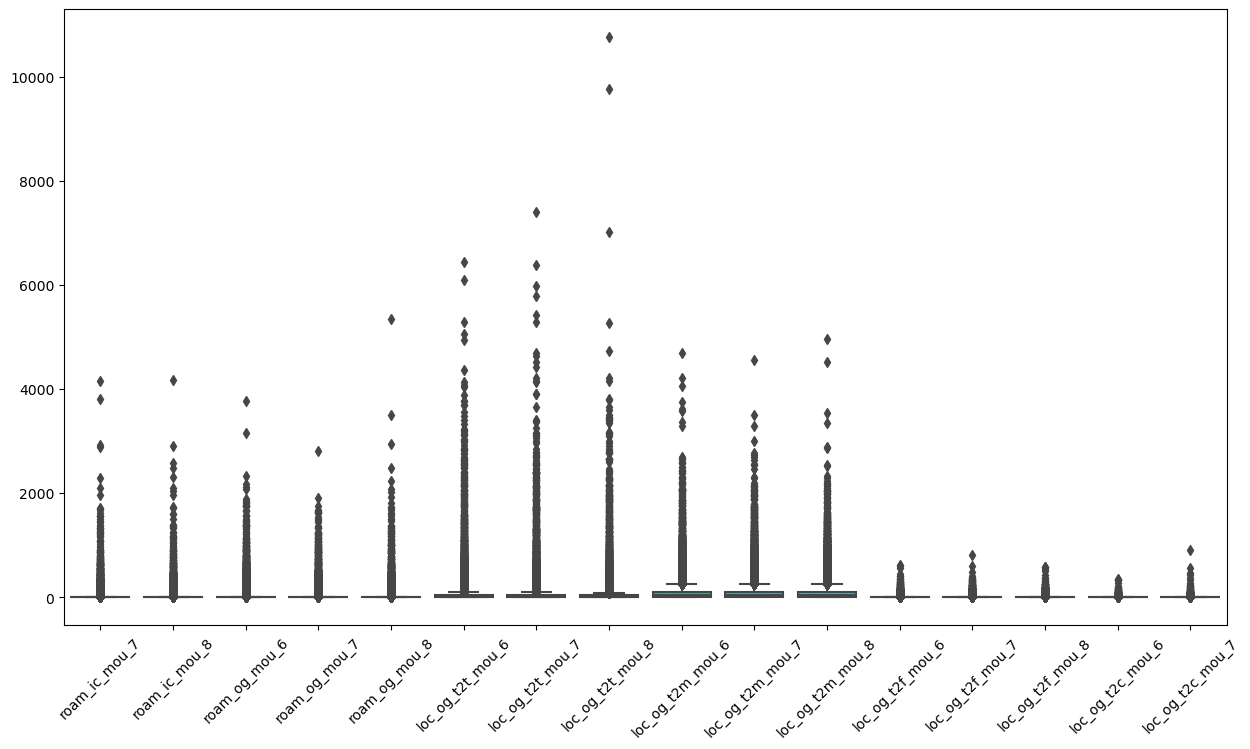

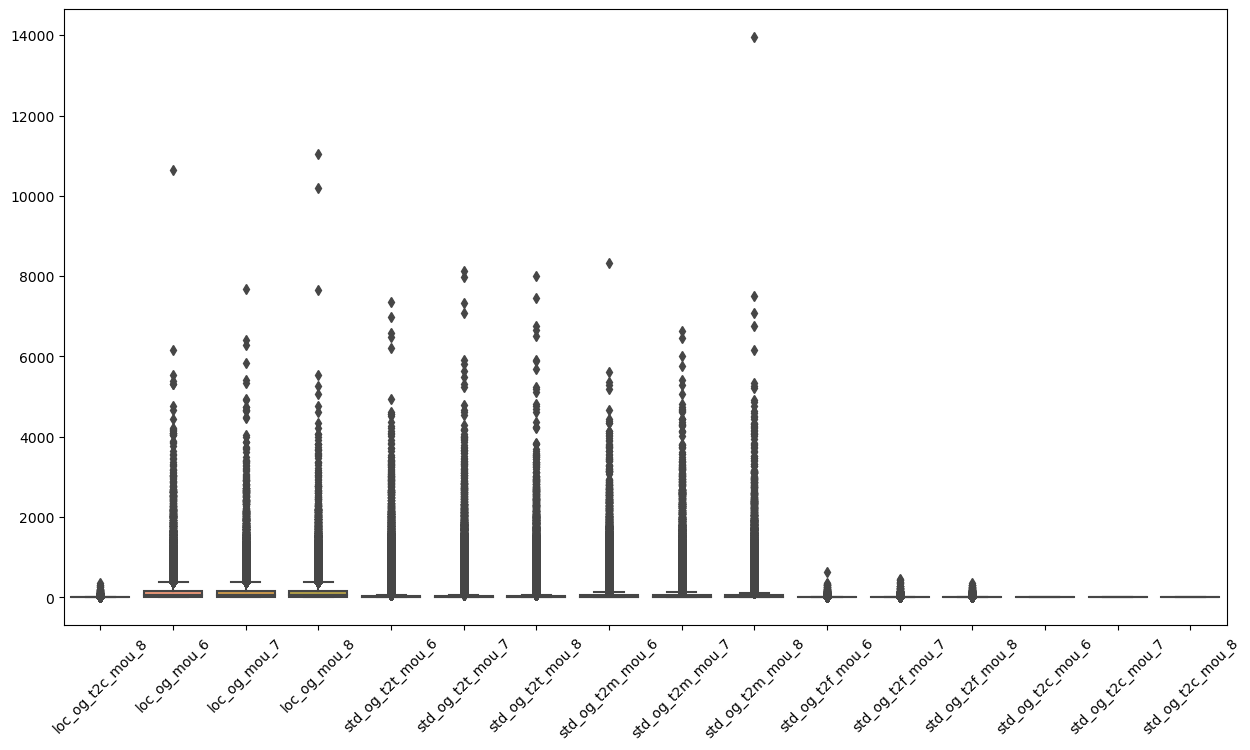

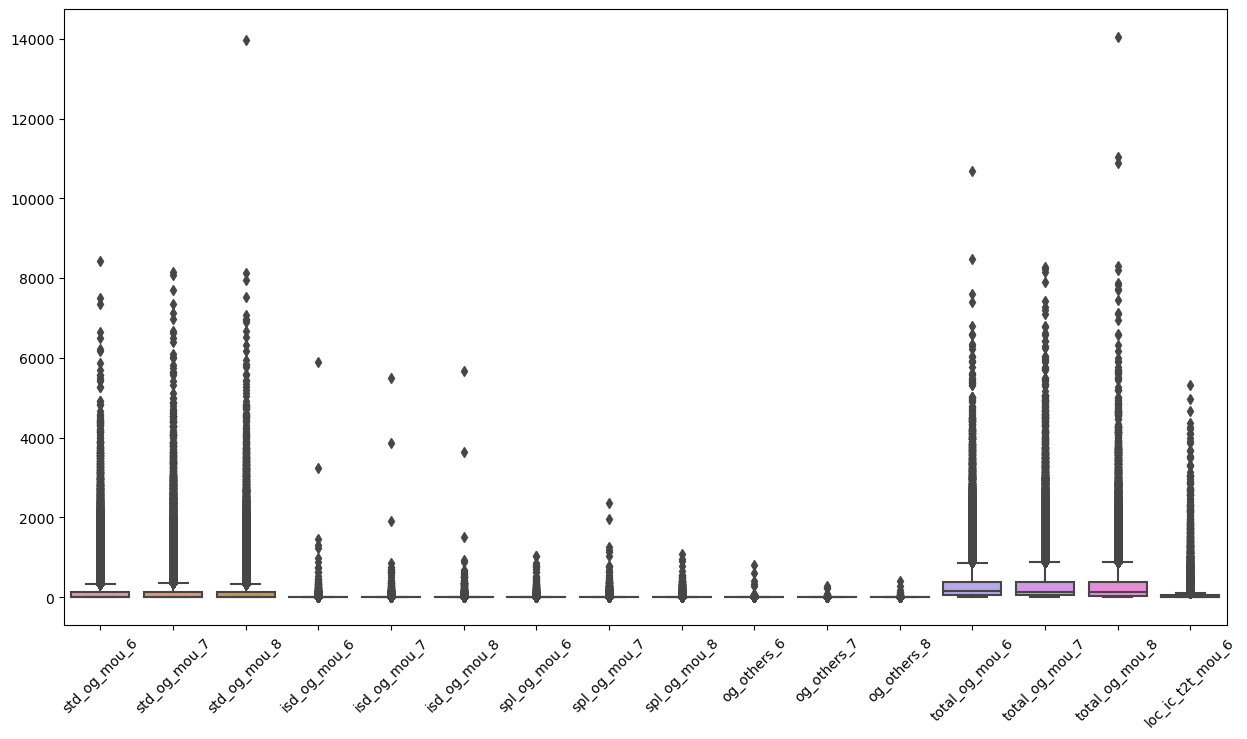

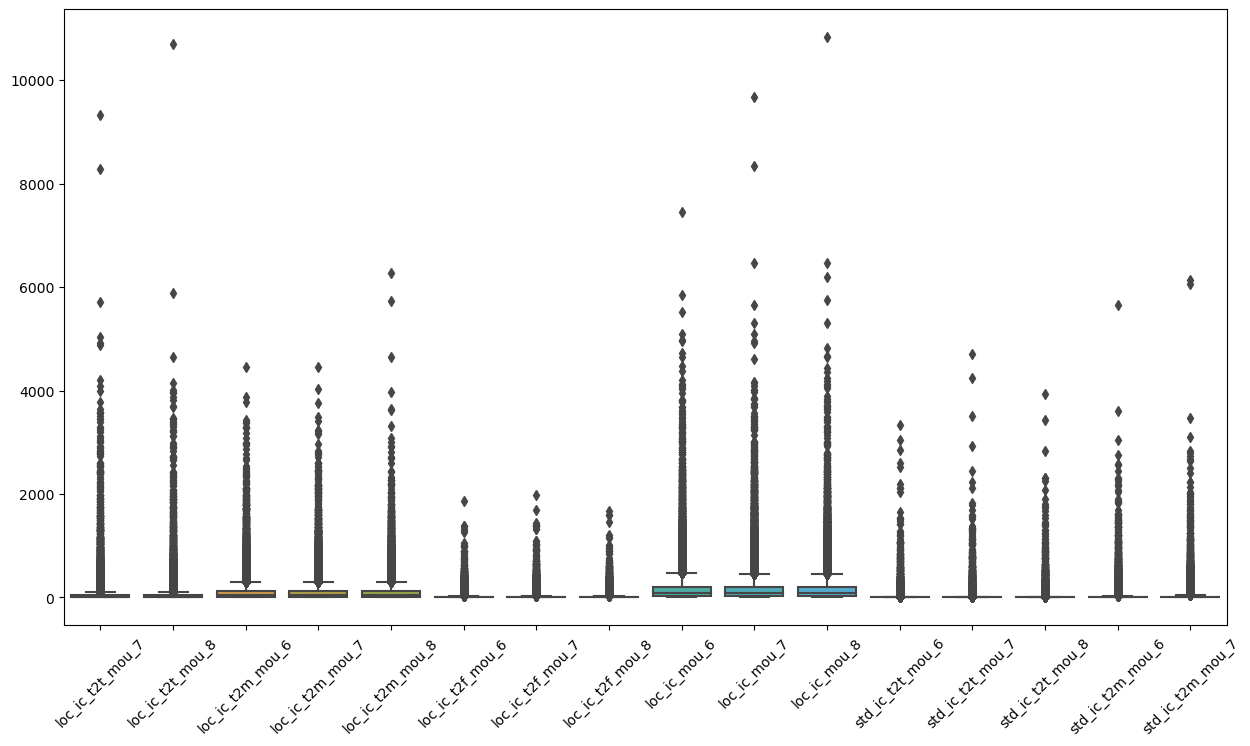

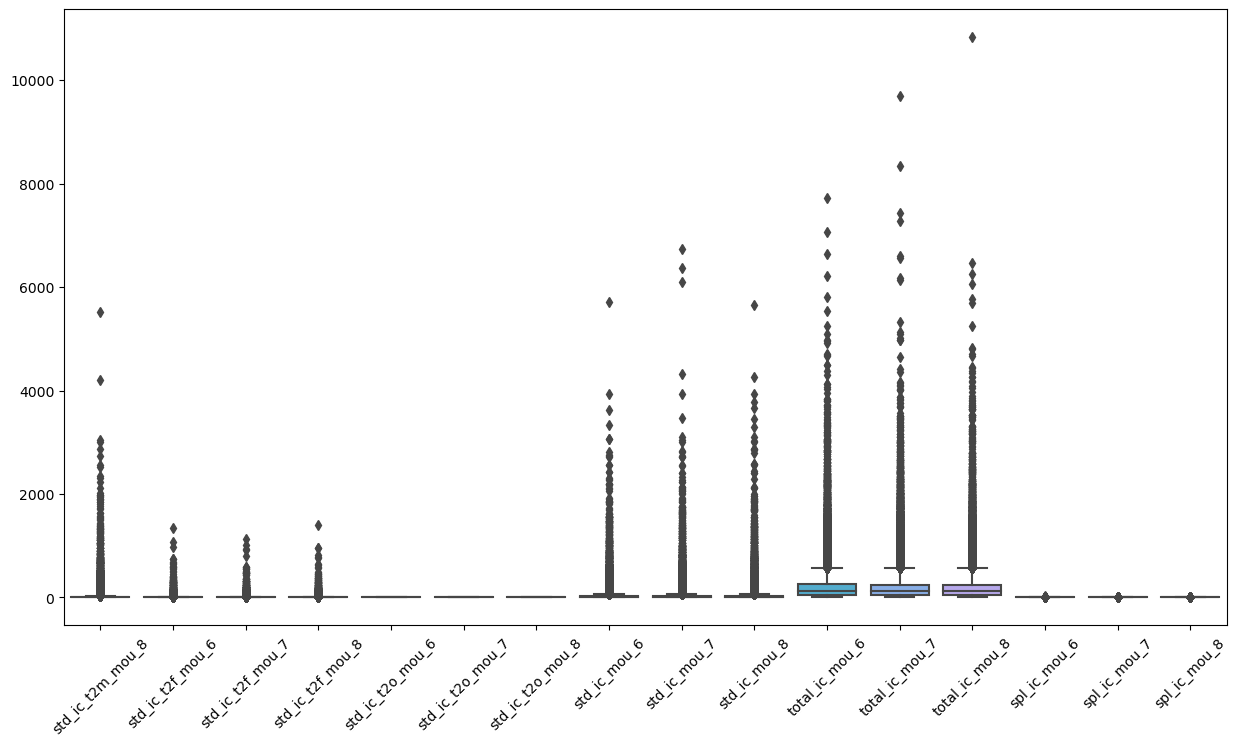

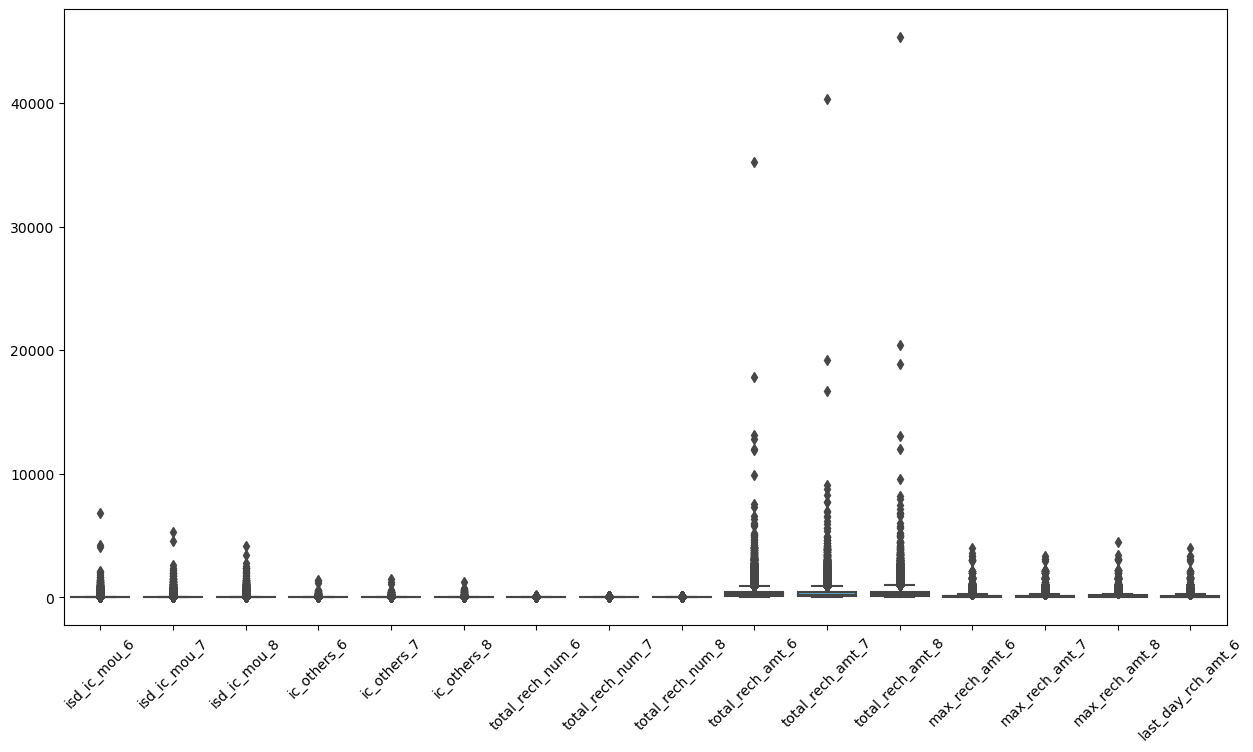

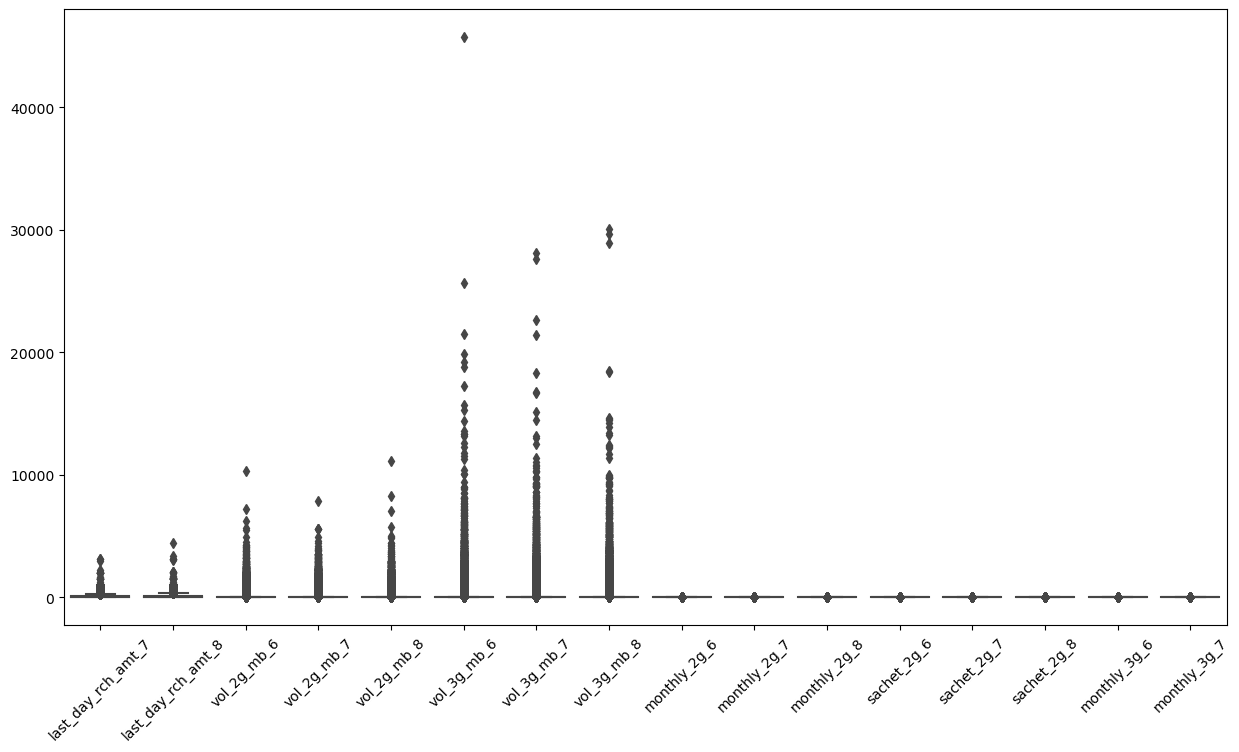

In [16]:
# Visualizing with the help of bar plot
# Since there are around 136 columns, viewing bar plot for all of the columns on X axis will not be possible.
# Let's divide the columns into 15 batches and run the box plot on them

show_box_plot_in_batches(data)

In [17]:
data.describe(percentiles=[.25,.5,.75,.90,.95,.99], include="all")

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,...,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69999.0,69999.0,69999.0,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,...,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.00000,69999.000000
mean,34999.000000,109.0,0.0,0.0,0.0,283.134365,278.185912,278.858826,127.887939,128.754731,...,0.077730,0.081958,0.075344,0.081444,0.085487,1220.639709,68.108597,65.935830,60.07674,0.101887
std,20207.115084,0.0,0.0,0.0,0.0,334.213918,344.366927,351.924315,295.115497,306.326345,...,0.383189,0.381821,0.573003,0.634547,0.680035,952.426321,269.328659,267.899034,257.22681,0.302502
min,0.000000,109.0,0.0,0.0,0.0,-2258.709000,-1289.715000,-945.808000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.00000,0.000000
25%,17499.500000,109.0,0.0,0.0,0.0,93.581000,86.714000,84.095000,5.430000,4.910000,...,0.000000,0.000000,0.000000,0.000000,0.000000,468.000000,0.000000,0.000000,0.00000,0.000000
50%,34999.000000,109.0,0.0,0.0,0.0,197.484000,191.588000,192.234000,30.830000,29.160000,...,0.000000,0.000000,0.000000,0.000000,0.000000,868.000000,0.000000,0.000000,0.00000,0.000000
75%,52498.500000,109.0,0.0,0.0,0.0,370.791000,365.369500,369.909000,113.100000,108.940000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1813.000000,0.000000,0.000000,0.00000,0.000000
90%,62998.200000,109.0,0.0,0.0,0.0,619.993800,615.661400,614.994600,331.766000,334.886000,...,0.000000,0.000000,0.000000,0.000000,0.000000,2792.000000,160.444000,136.272000,110.32800,1.000000
95%,66498.100000,109.0,0.0,0.0,0.0,832.022700,823.236700,828.464700,598.600000,608.878000,...,1.000000,1.000000,0.000000,0.000000,0.000000,3108.000000,464.277000,446.353000,400.13400,1.000000
99%,69298.020000,109.0,0.0,0.0,0.0,1400.276640,1414.891380,1445.054800,1429.040400,1461.342200,...,2.000000,2.000000,2.000000,2.000000,2.000000,3651.000000,1226.659800,1254.279000,1188.26780,1.000000


In [18]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [19]:
data_new = data.apply(cap_outliers, axis=0)

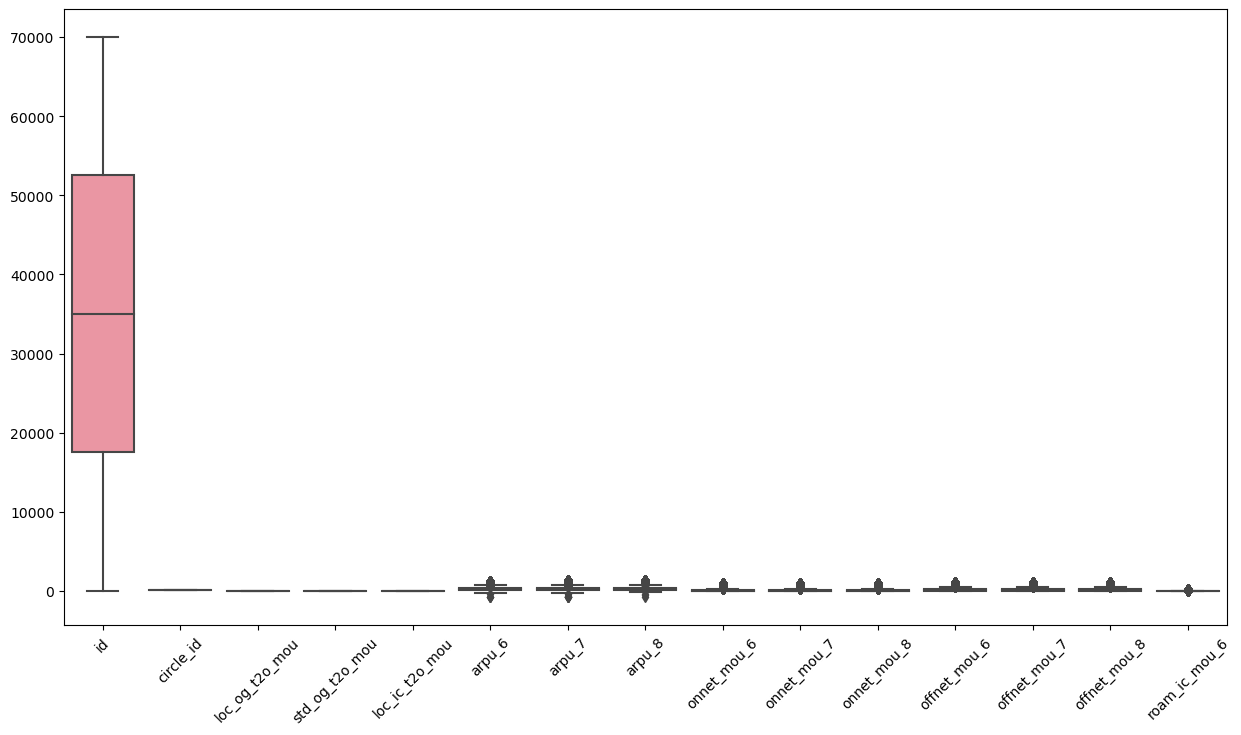

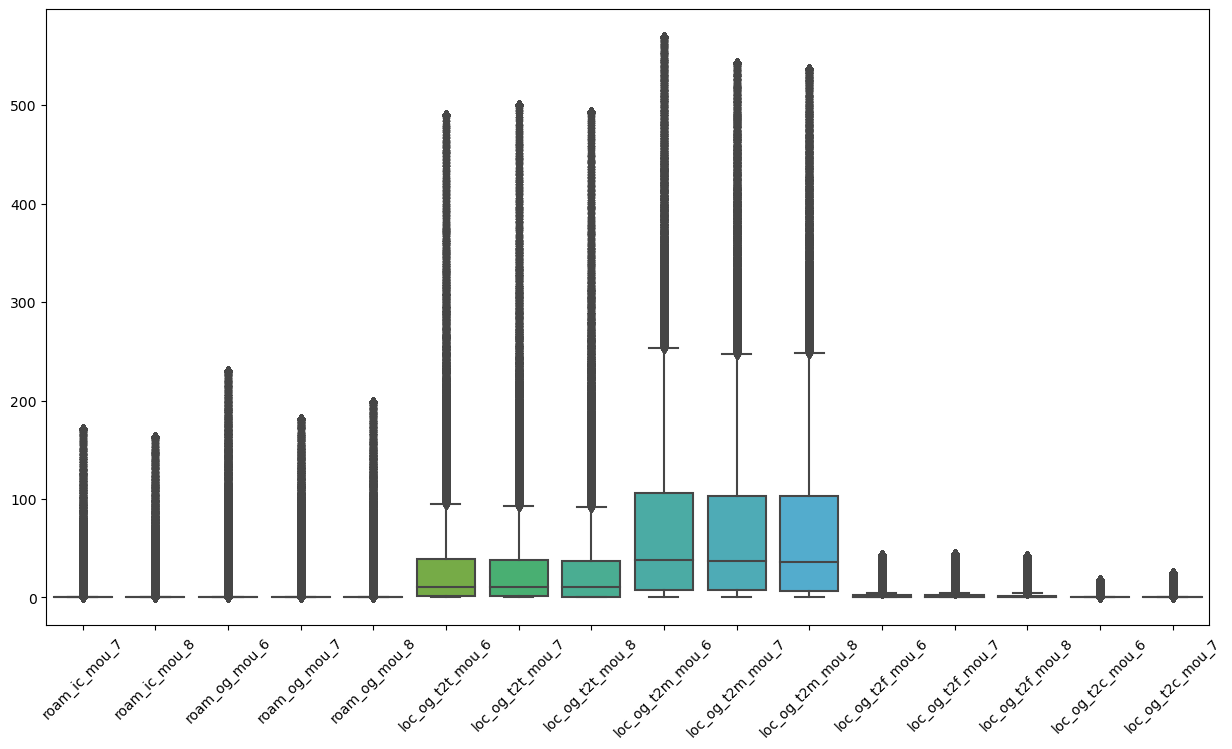

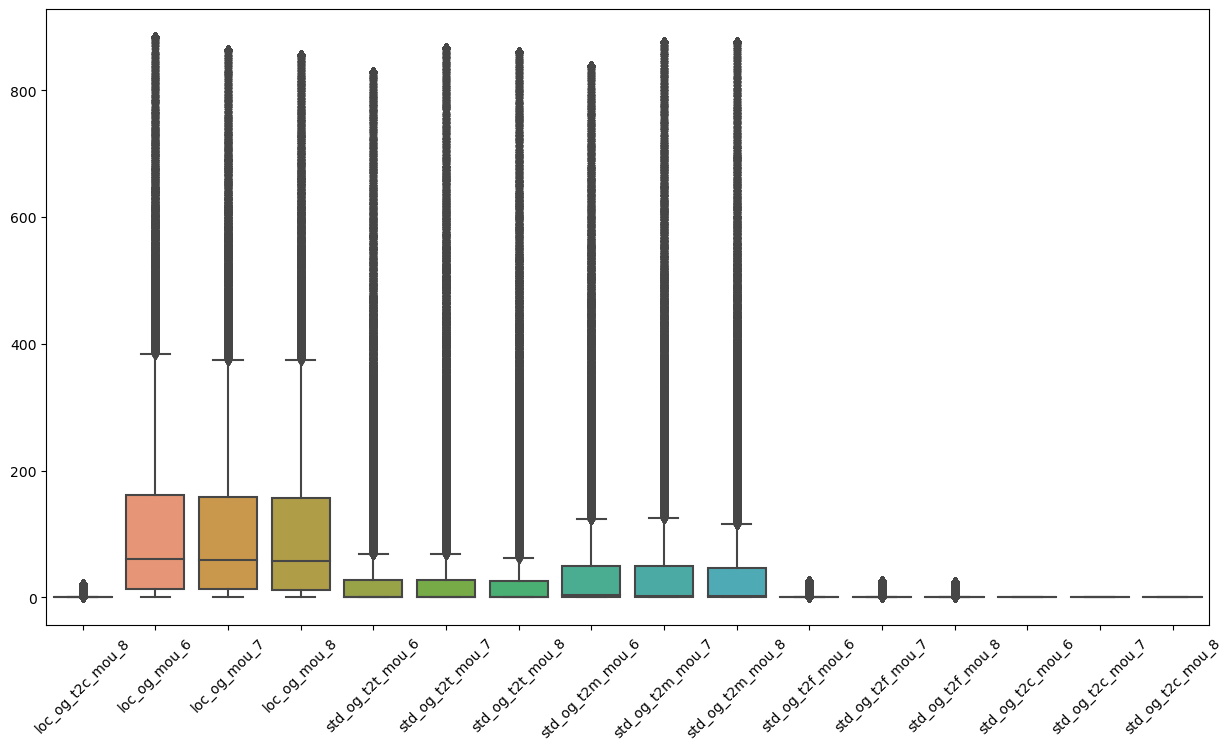

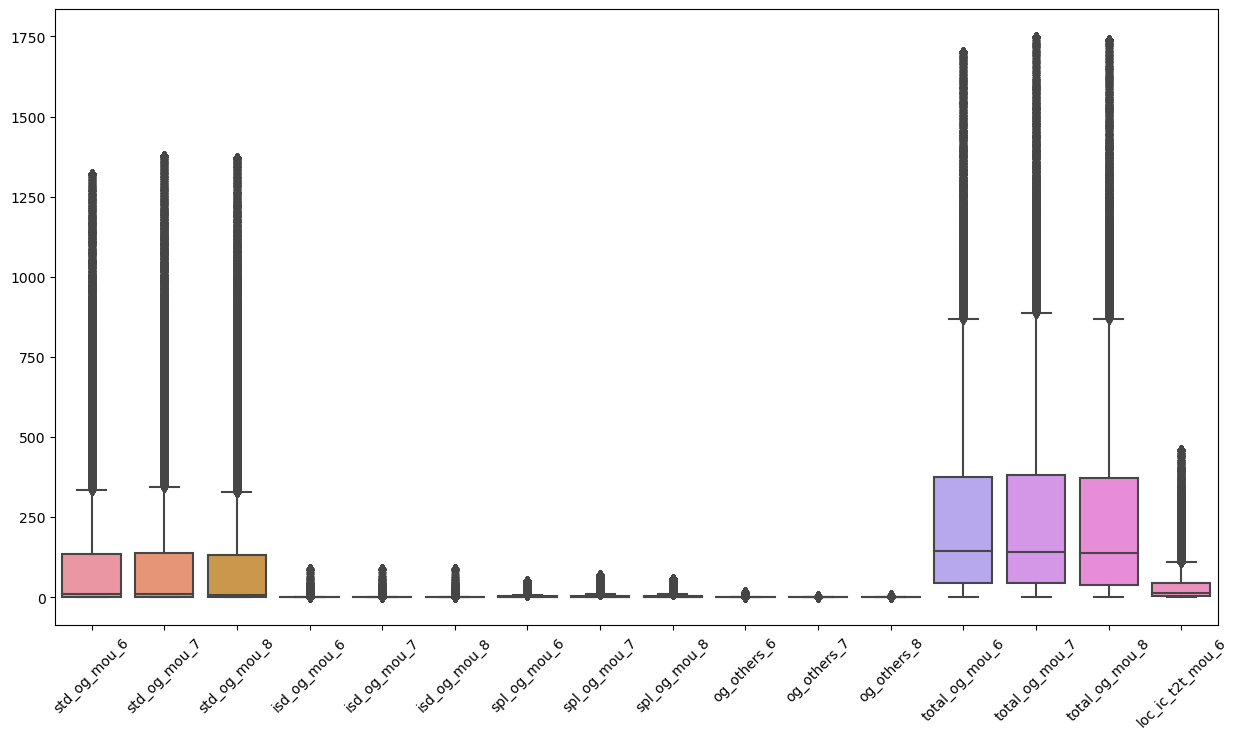

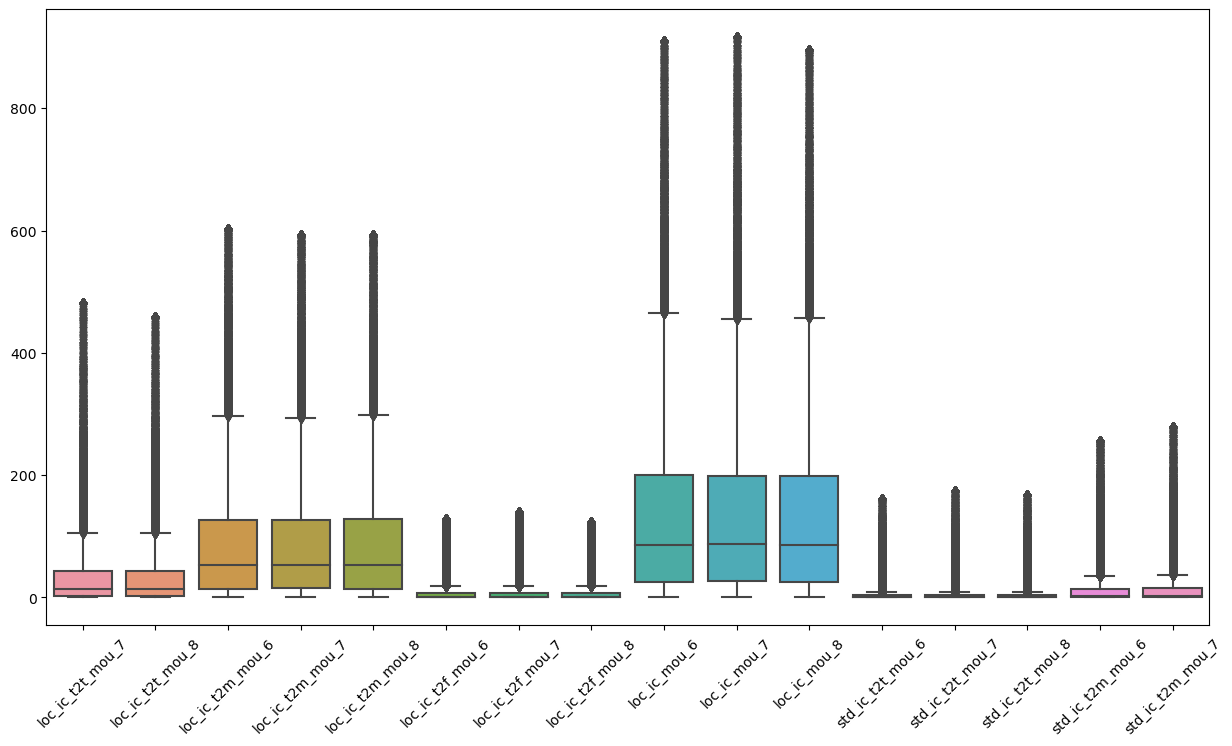

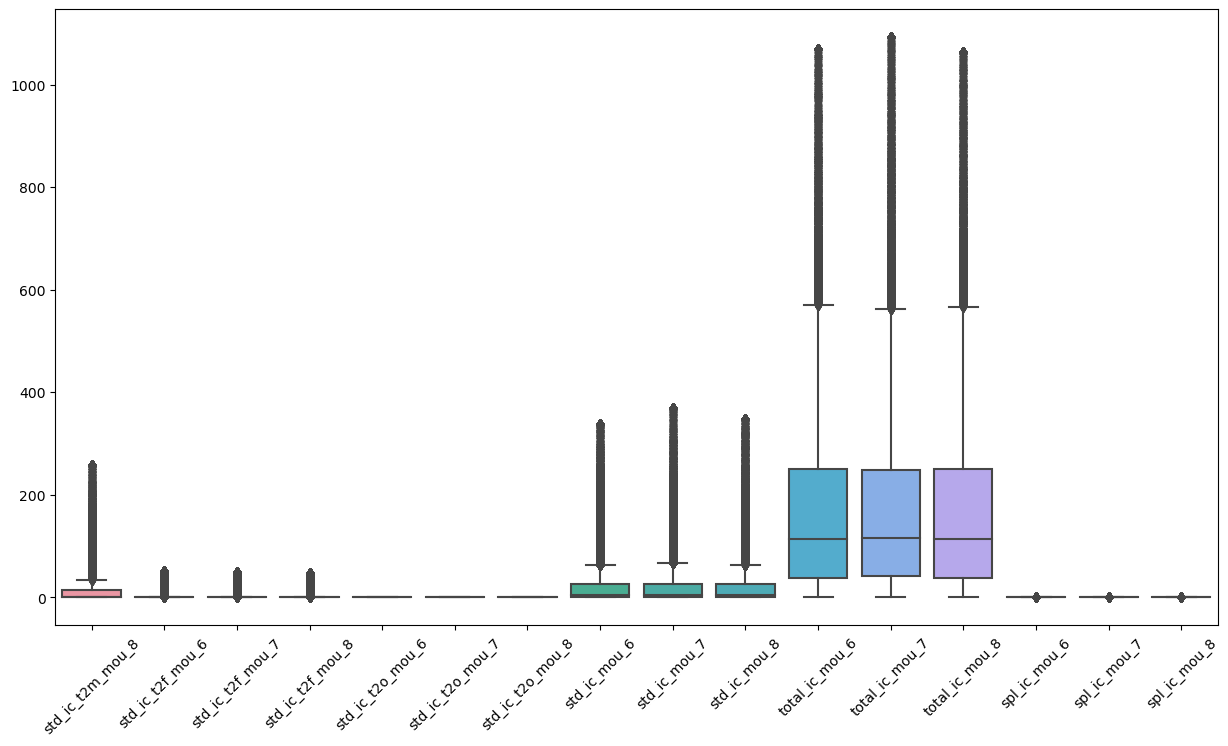

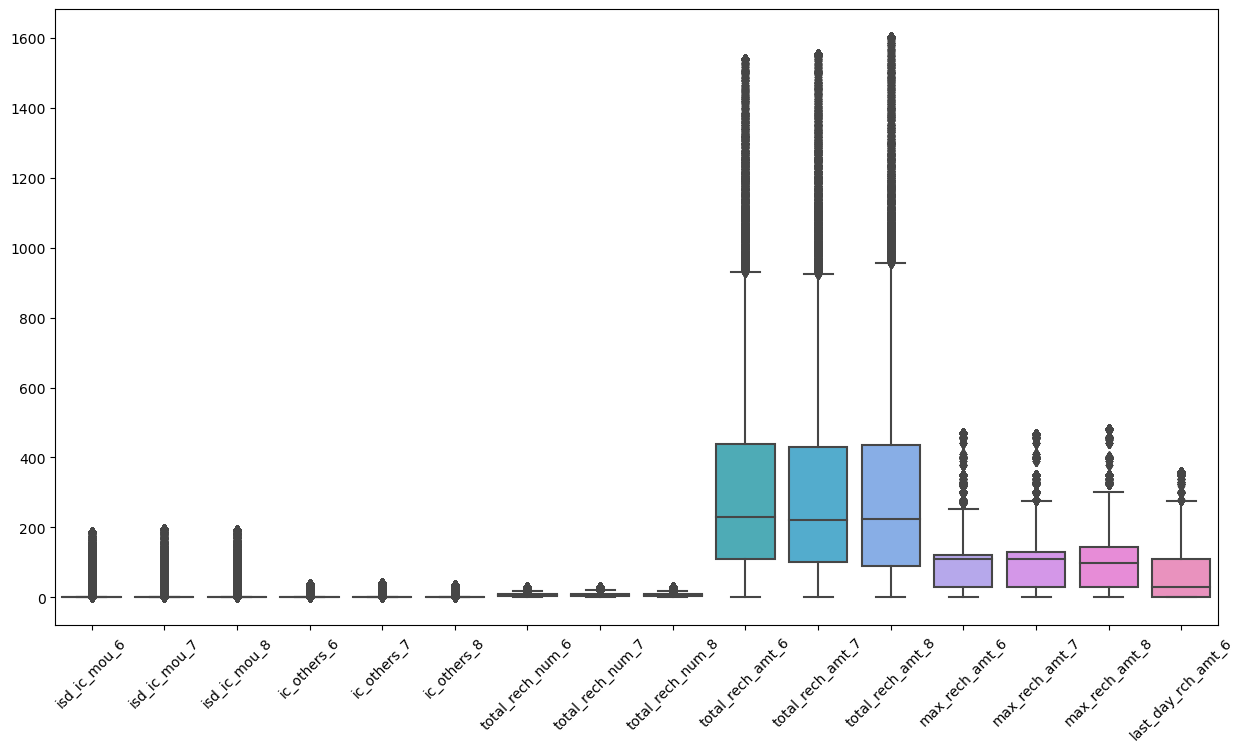

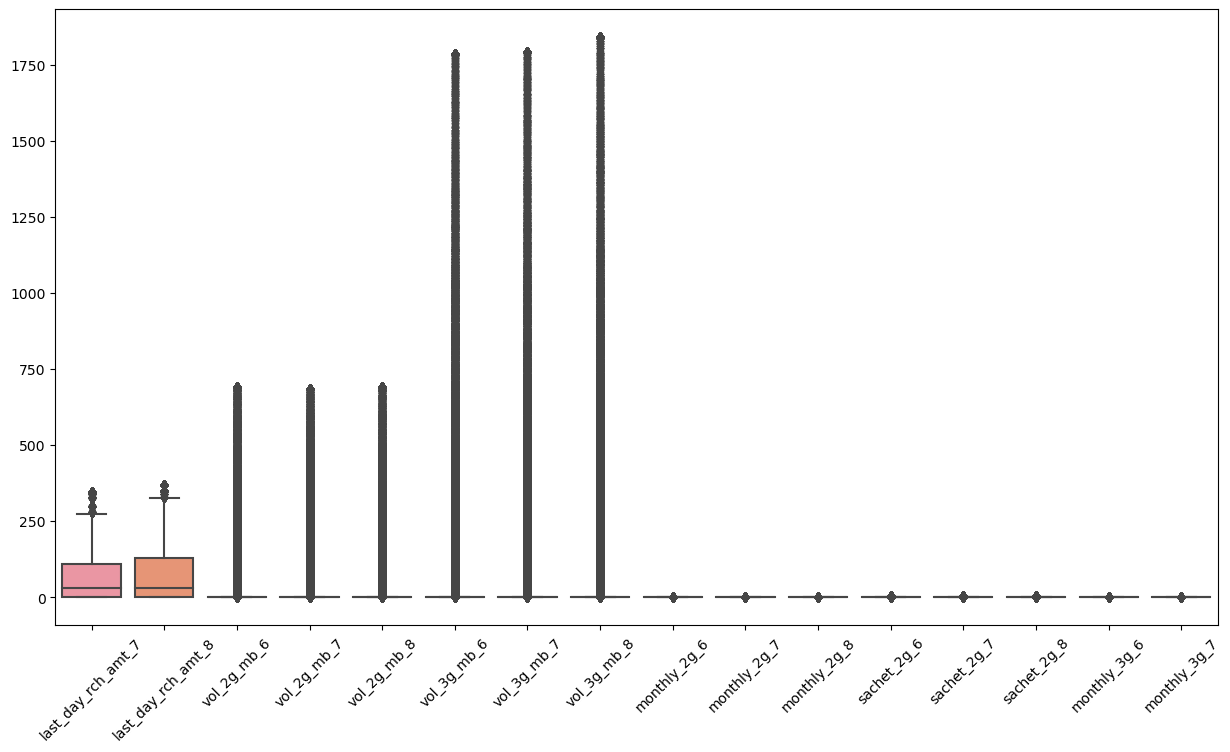

In [20]:
show_box_plot_in_batches(data_new)

In [21]:
# Getting X and y dataframe and splitting into train and test dataset
data_new = data_new.drop(columns=["id","circle_id"])
y = data_new.pop("churn_probability")
X = data_new

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((48999, 133), (21000, 133), (48999,), (21000,))

##### Let's print correlations for each feature using heatmap

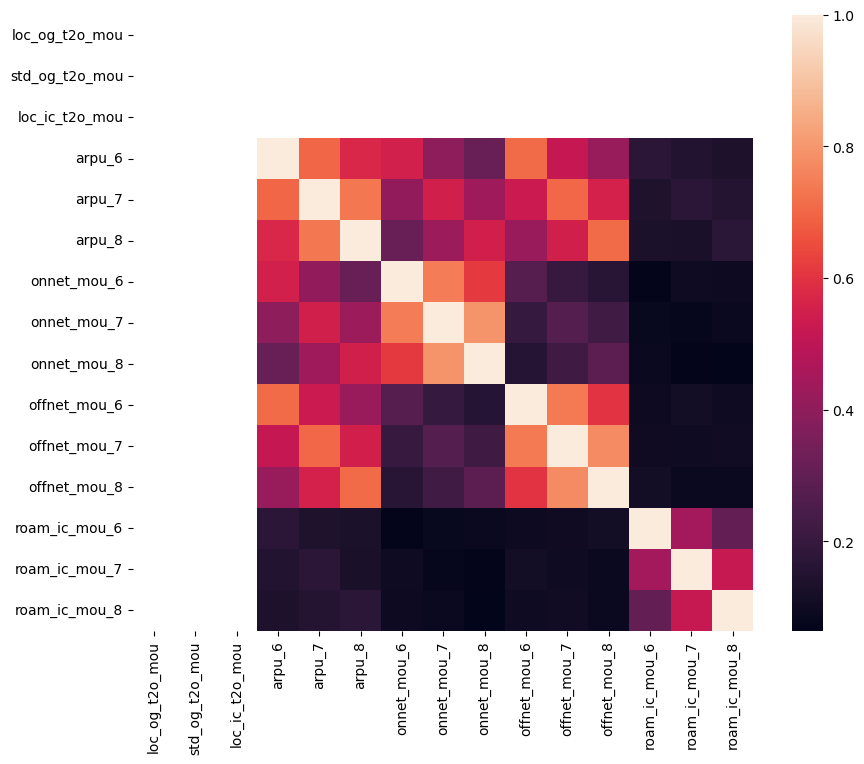

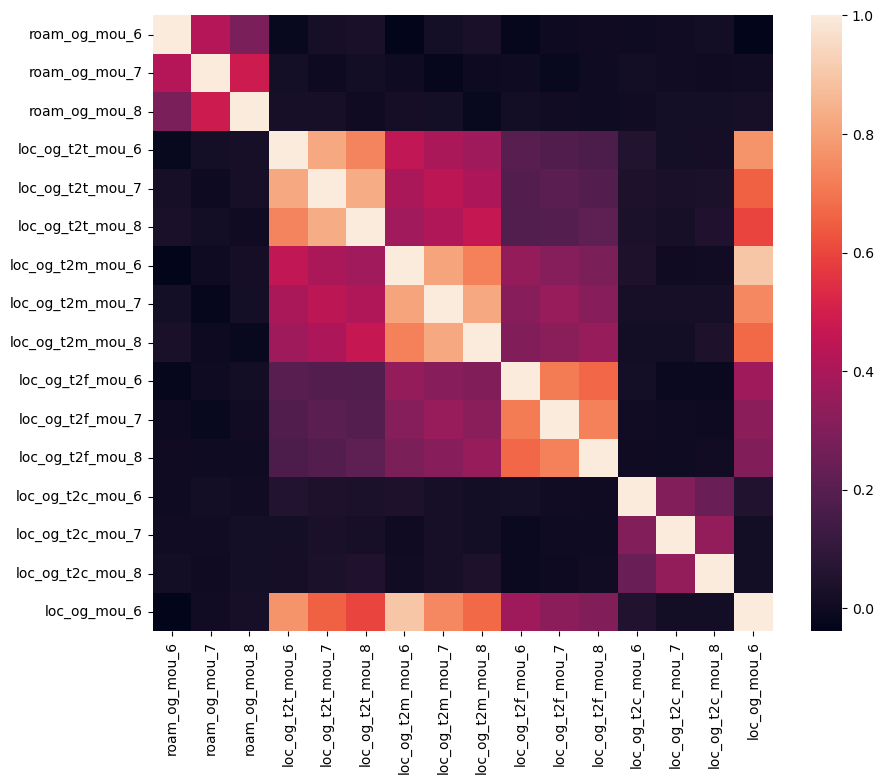

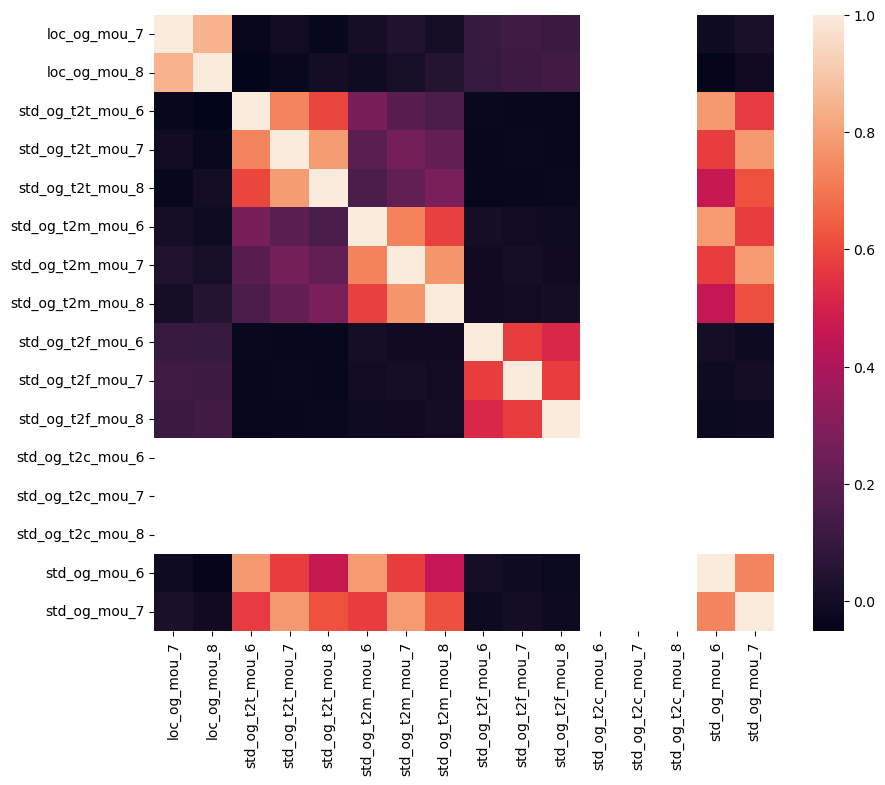

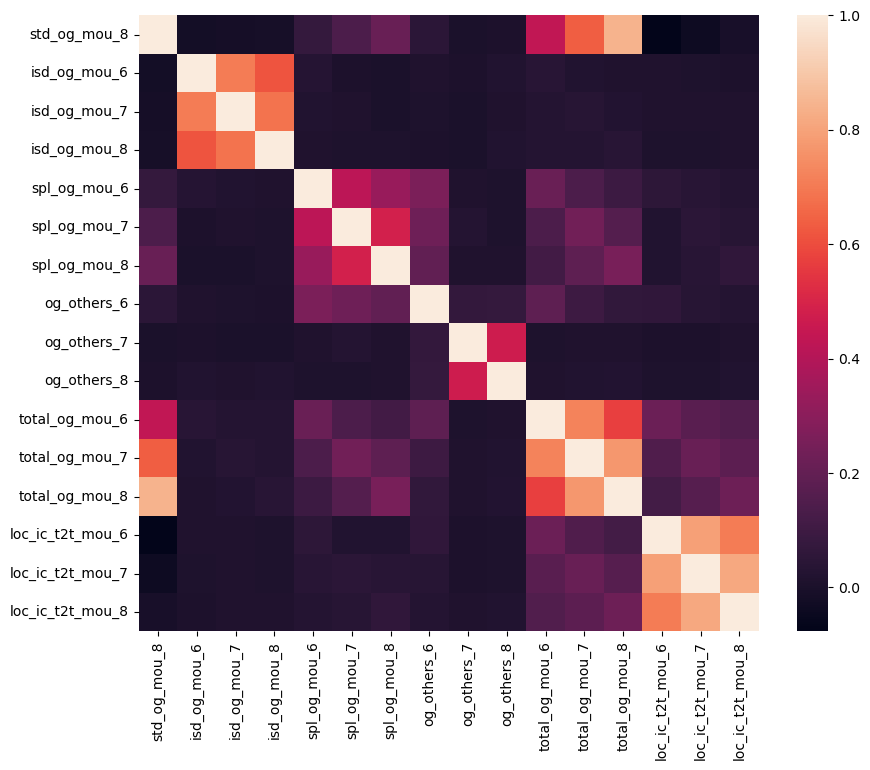

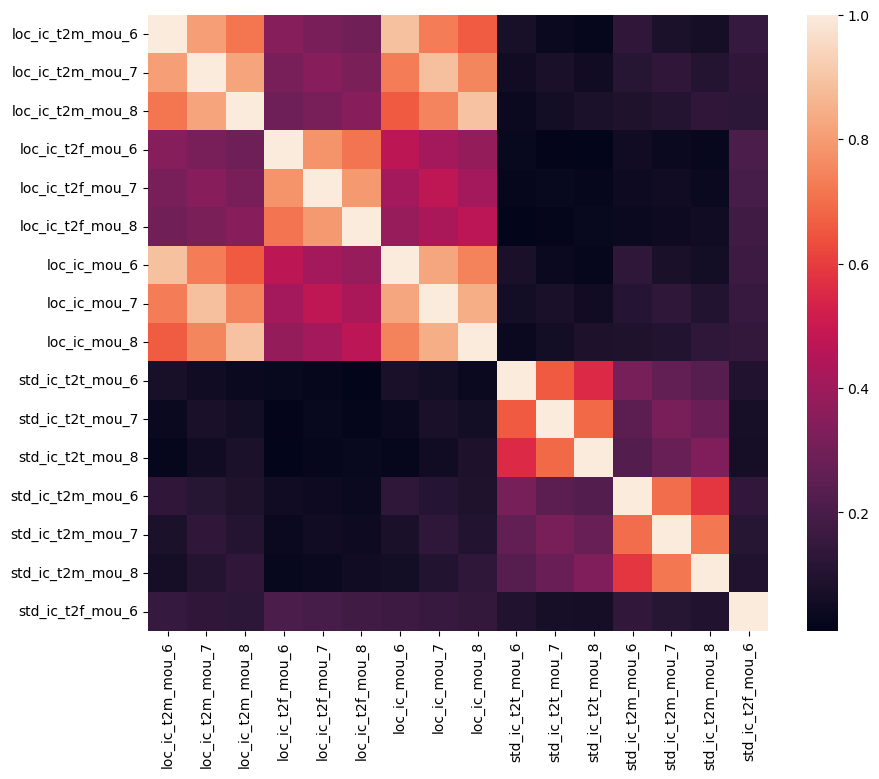

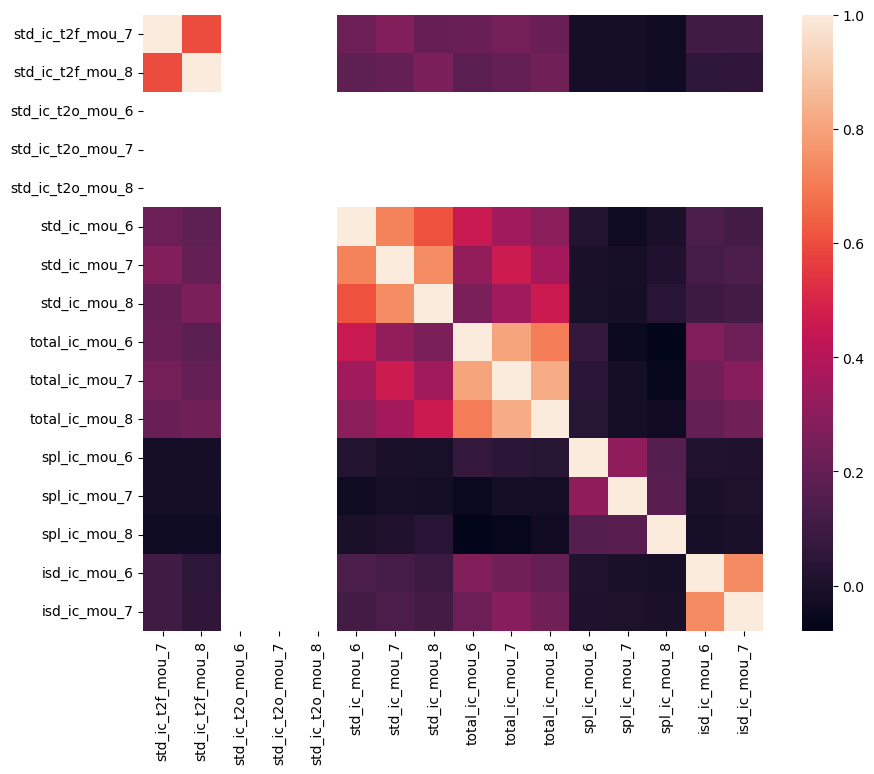

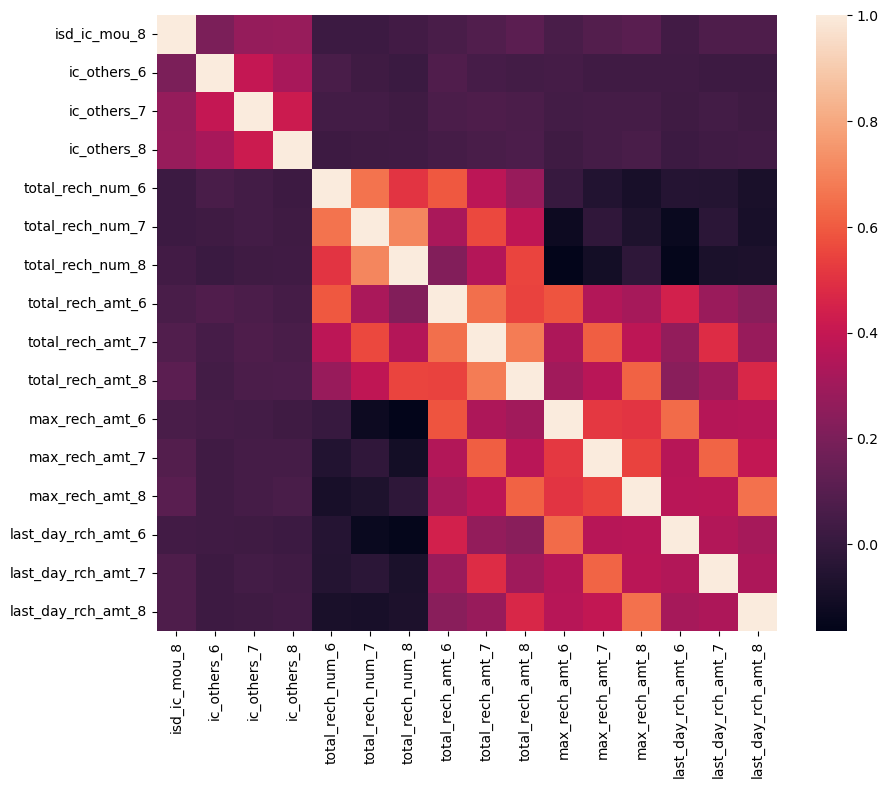

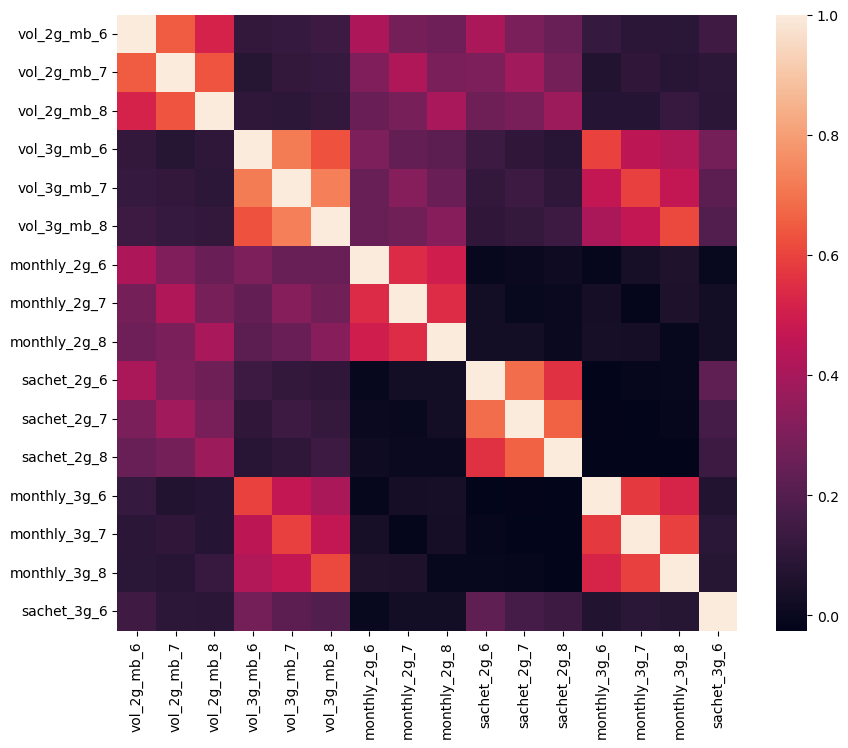

In [23]:
prev=0
for i in range(15,len(X_train.columns),16):
    plt.figure(figsize=(10,8))
    sns.heatmap(pd.DataFrame(X_train, columns=X_train.iloc[:,prev:i].columns).corr())
    prev = i

### Feature Engineering and Variable Transformation 

##### Feature scaling

In [24]:
X_train

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g
9830,0.0,0.0,0.0,985.053,723.303,889.042,484.86,405.38,584.99,483.93,...,0.0,0.0,0.0,1.0,0.0,0.0,3651.0,0.00,0.0,0.0
23914,0.0,0.0,0.0,76.191,85.905,516.776,86.41,36.21,64.28,18.28,...,0.0,0.0,0.0,0.0,0.0,0.0,695.0,0.00,0.0,0.0
19197,0.0,0.0,0.0,0.000,214.339,427.478,0.00,0.00,33.11,0.00,...,0.0,1.0,0.0,0.0,0.0,0.0,2373.0,128.64,0.0,0.0
47702,0.0,0.0,0.0,45.498,116.272,359.445,7.89,14.34,16.59,33.36,...,0.0,0.0,1.0,0.0,0.0,0.0,738.0,93.47,0.0,0.0
56410,0.0,0.0,0.0,668.305,638.031,730.657,175.31,289.21,505.09,645.09,...,0.0,0.0,0.0,0.0,0.0,0.0,1164.0,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38542,0.0,0.0,0.0,206.190,133.699,178.459,132.61,71.64,27.39,218.08,...,0.0,0.0,0.0,0.0,0.0,0.0,3301.0,0.00,0.0,0.0
19115,0.0,0.0,0.0,49.520,80.278,82.570,32.86,44.96,32.26,35.91,...,0.0,0.0,0.0,0.0,0.0,0.0,286.0,0.00,0.0,0.0
49235,0.0,0.0,0.0,125.690,106.242,825.929,12.16,0.00,80.39,113.03,...,0.0,0.0,0.0,0.0,0.0,0.0,458.0,0.00,0.0,0.0
61511,0.0,0.0,0.0,0.000,0.000,321.523,0.00,0.00,155.26,2.93,...,0.0,0.0,0.0,0.0,0.0,0.0,1437.0,0.00,0.0,0.0


In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [26]:
X_train

array([[ 0.        ,  0.        ,  0.        , ..., -0.31789285,
        -0.30871888, -0.30035726],
       [ 0.        ,  0.        ,  0.        , ..., -0.31789285,
        -0.30871888, -0.30035726],
       [ 0.        ,  0.        ,  0.        , ...,  0.42488757,
        -0.30871888, -0.30035726],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.31789285,
        -0.30871888, -0.30035726],
       [ 0.        ,  0.        ,  0.        , ..., -0.31789285,
        -0.30871888, -0.30035726],
       [ 0.        ,  0.        ,  0.        , ..., -0.31789285,
        -0.30871888, -0.30035726]])

##### Applying PCA on data

In [27]:
pca = PCA(random_state=42)
pca.fit(X_train)

PCA(random_state=42)

In [28]:
pca.components_

array([[ 3.02063341e-19,  5.55111512e-17,  1.11022302e-16, ...,
         4.53905226e-02,  4.52581918e-02,  4.26583328e-02],
       [ 4.35686413e-19, -5.55111512e-17, -1.11022302e-16, ...,
        -5.88935599e-02, -5.91438505e-02, -5.76446835e-02],
       [ 1.68478393e-18,  1.11022302e-16,  0.00000000e+00, ...,
         2.57794052e-01,  2.64380663e-01,  2.51963820e-01],
       ...,
       [ 0.00000000e+00,  2.07221662e-02,  2.85586174e-04, ...,
         1.21430643e-16, -4.91956736e-18, -1.01264483e-16],
       [-0.00000000e+00,  3.58431502e-02, -1.77220265e-02, ...,
         3.55618313e-17, -7.32920669e-17, -6.66242235e-17],
       [ 9.99996753e-01,  1.70165673e-03,  1.89642502e-03, ...,
         7.31836466e-19,  1.40946282e-18, -4.33680869e-19]])

In [29]:
pca.explained_variance_ratio_

array([1.60434110e-01, 8.74992679e-02, 5.55534280e-02, 4.66133924e-02,
       3.70405952e-02, 2.98346585e-02, 2.83972762e-02, 2.60796823e-02,
       2.48161252e-02, 2.36561010e-02, 2.12201013e-02, 2.10513242e-02,
       1.87850918e-02, 1.77561811e-02, 1.66853053e-02, 1.51957293e-02,
       1.34280570e-02, 1.29099575e-02, 1.22880647e-02, 1.19460377e-02,
       1.18051248e-02, 1.12656788e-02, 1.10920337e-02, 1.05645025e-02,
       9.40340983e-03, 9.22901654e-03, 8.87545289e-03, 8.65707003e-03,
       7.78746656e-03, 7.62561444e-03, 7.42310566e-03, 7.08651565e-03,
       6.96855122e-03, 6.80528981e-03, 6.58663202e-03, 6.28171366e-03,
       6.02131353e-03, 5.96809944e-03, 5.75900835e-03, 5.64773914e-03,
       5.45849911e-03, 5.27646566e-03, 5.16771345e-03, 5.11396575e-03,
       4.65055807e-03, 4.56864775e-03, 4.50877626e-03, 4.48449635e-03,
       4.39804596e-03, 4.27039900e-03, 4.22347418e-03, 4.11619860e-03,
       3.86927736e-03, 3.83357882e-03, 3.77197207e-03, 3.47875775e-03,
      

In [30]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

##### Making a scree plot to know how many variables explain the maximum variance

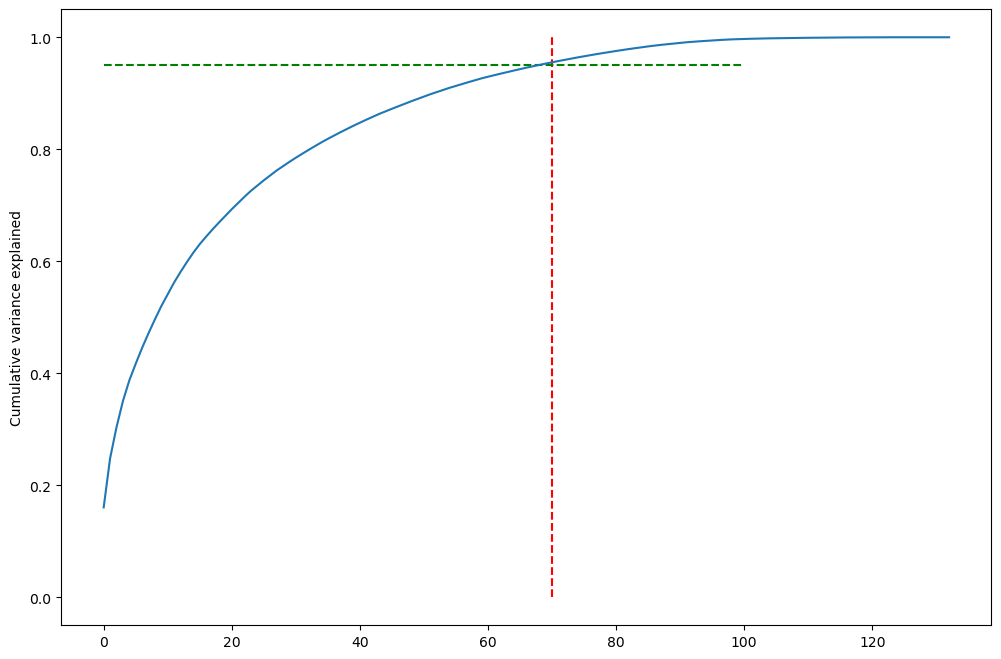

In [31]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=70, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=100, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

##### As we can see clearly, around 95% of the variance is explained by using 70 features. Hence we will be using 70 variabels to build PCA model

In [32]:
pc2 = PCA(n_components=70, random_state=42)
transformed_data = pc2.fit_transform(X_train)

In [33]:
transformed_data.shape

(48999, 70)

In [34]:
df_train_pca = pd.DataFrame(transformed_data)
df_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,3.910898,3.076523,7.553302,-0.078178,-7.668896,-0.802235,4.484399,14.740311,3.444590,-1.608187,...,0.974046,-0.834789,-0.497601,-0.456499,-0.701476,0.029731,0.113074,0.108120,0.382061,-0.789818
1,-1.593976,-0.743578,0.959257,2.586113,1.083744,0.547286,-1.923265,-1.827372,8.957893,2.993188,...,-0.202422,1.948008,0.127409,-0.515372,1.567806,0.393641,-0.499332,3.799108,-0.363893,-0.312563
2,-2.741435,-0.733914,3.223584,0.179073,-1.197774,-0.262052,-0.807902,2.665382,0.545036,-0.852661,...,-0.354409,0.727908,0.414048,-0.669181,-0.597972,0.653611,-0.337123,0.033799,-0.524147,-0.016855
3,-2.290517,-1.118206,1.062722,-0.700675,-0.517155,0.030382,-1.611380,-0.134541,-0.810022,1.234607,...,-0.138815,0.328709,-0.015184,-0.536014,-0.087884,0.141997,0.501138,0.145961,0.209771,0.079484
4,8.353483,3.132541,-2.379694,-0.301628,-0.187121,0.992445,-0.756557,0.084178,-1.967430,1.893650,...,-0.083244,0.036758,0.272580,0.442161,-0.161811,0.853683,0.028417,-0.027883,-0.114309,-0.320628


In [35]:
corrmat = np.corrcoef(df_train_pca.transpose())

<Axes: >

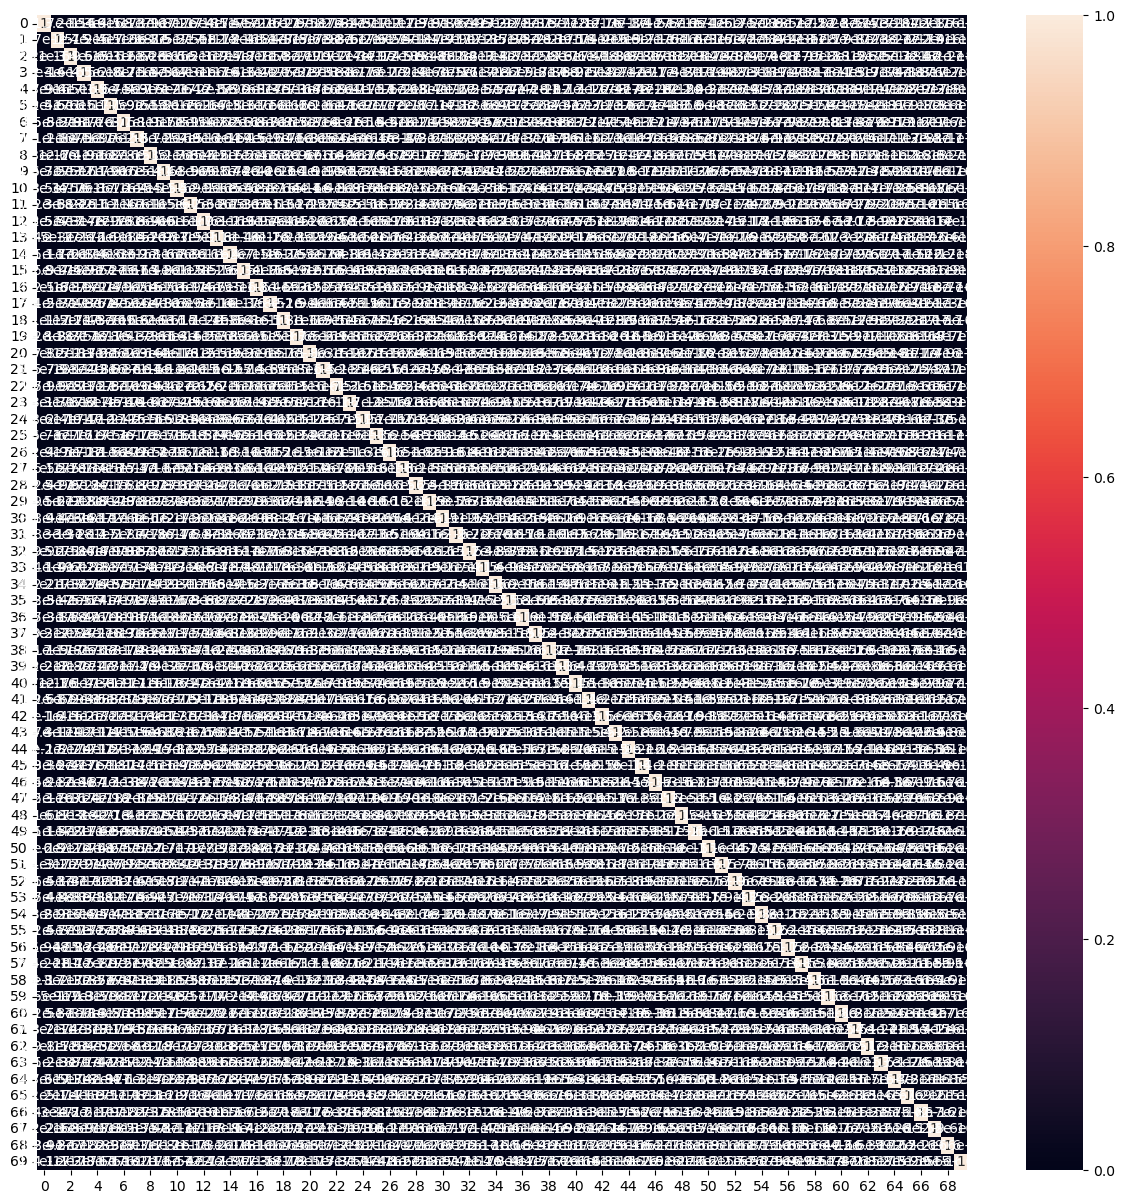

In [36]:
# Let's plot the heatmap of the coefficients obtained from pca model. 
# After the dimentionality reduction, the newly obtain coefficients should not be correlated to each other
plt.figure(figsize=[15,15])
sns.heatmap(corrmat, annot=True)

##### As we can see, the newly obtained 69 coefficients are not correlated to each other

##### Let's build logistic regression model on top of transformed data received from PCA and predict the churn probability

In [37]:
logisticRegression = LogisticRegression()

In [38]:
lrmodel = logisticRegression.fit(df_train_pca, y_train)

In [39]:
# Applying transformation on test data set to reduce dimentionality and get more uncorrelated features
df_test_pca = pc2.transform(X_test)
df_test_pca.shape

(21000, 70)

In [40]:
y_train_pred = lrmodel.predict(df_train_pca)
pred_probs_train = lrmodel.predict_proba(df_train_pca)

In [ ]:
y_test_pred = lrmodel.predict(df_test_pca)
pred_probs_test = lrmodel.predict_proba(df_test_pca)

In [ ]:
"{:2.2}".format(metrics.roc_auc_score(y_train, pred_probs_train[:,1]))

In [ ]:
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test[:,1]))

##### Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [ ]:
confusion_matrix(y_train, y_train_pred)

In [ ]:
confusion_matrix(y_test, y_test_pred)

In [ ]:
precision_score(y_test, y_test_pred)

In [ ]:
recall_score(y_test, y_test_pred)